In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import umap
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.preprocessing import normalize


In [2]:
# def standardize_embeddings_array(emb_array: np.ndarray) -> np.ndarray:
#     """
#     Standardize a 2D array of embeddings (mean=0, std=1 per column).
#     """
#     mean = np.mean(emb_array, axis=0)
#     std = np.std(emb_array, axis=0)
#     std[std == 0] = 1e-8  # Prevent divide-by-zero
#     return (emb_array - mean) / std

# df = pd.read_json("results/task2/task2_data.json", lines=True)
# # --- Step 1: Expand lists to 2D arrays ---
# ref_array = np.vstack(df["ref_embeddings"].to_numpy())
# gen_array = np.vstack(df["gen_embeddings"].to_numpy())

# # --- Step 2: Standardize ---
# ref_std = standardize_embeddings_array(ref_array)
# gen_std = standardize_embeddings_array(gen_array)

# # --- Step 3: Store back in DataFrame ---
# df["ref_std"] = list(ref_std)
# df["gen_std"] = list(gen_std)

# zone_path = "datasets/job_zone.xlsx"
# zone = pd.read_excel(zone_path)
# zone = zone[['Title', 'Job Zone']]
# zone.columns = ['title', 'zone']
# df = df.merge(zone, left_on='title', right_on='title', how='left')
# df_std = df.copy()
# df_std = df_std.drop(columns=["ref_embeddings", "gen_embeddings"])
# df_std["cos_sim_std"] = [
#     cosine_similarity([r], [g])[0][0]
#     for r, g in zip(df_std["ref_std"], df_std["gen_std"])
# ]
# df_std["industry"] = df_std["code"].apply(lambda x: x.split("-")[0])
# df_std["industry"] = df_std["industry"].astype("category")
# df_std["code"] = df_std["code"].astype("category")
# df_std["zone"] = df_std["zone"].astype("category")
# df_std = df_std.drop(columns=["ref_std", "gen_std"])

# df_std.to_json(
#     "results/task2/task2_data_std.json",
#     lines=True,
#     orient="records",
#     force_ascii=False,
#     index=False,
# )

### Regression

In [3]:
df = pd.read_json("results/task2/task2_data_std.json", lines=True)
#change values of "model", llama 70b to "llama-70b"
df["model"] = df["model"].replace("llama 70b", "llama70b")
df["model"] = df["model"].replace("llama 3b", "llama 3b")
df["model"] = df["model"].apply(lambda x: x.split(" ")[0] if " " in x else x)
df_model = df[df["model"] == "mistral"].copy()
df_model

,title,code,iteration,model,prompt,zone,cos_sim_std,industry
52740,"Potters, Manufacturing",51-9195.05,8,mistral,benchmark,3,0.801784,51
52741,"Pourers and Casters, Metal",51-4052.00,8,mistral,benchmark,2,0.758061,51
52742,Power Distributors and Dispatchers,51-8012.00,8,mistral,benchmark,3,0.803365,51
52743,Power Plant Operators,51-8013.00,8,mistral,benchmark,2,0.660010,51
52744,Precision Agriculture Technicians,19-4012.01,8,mistral,benchmark,3,0.883189,19
...,...,...,...,...,...,...,...,...
70315,Information Security Analysts,15-1212.00,2,mistral,persona,4,0.698968,15
70316,Information Technology Project Managers,15-1299.09,2,mistral,persona,4,0.858831,15
70317,"Inspectors, Testers, Sorters, Samplers, and We...",51-9061.00,2,mistral,persona,2,0.522595,51
70318,Instructional Coordinators,25-9031.00,2,mistral,persona,5,0.779383,25


Calculating average cosine similarity per job per prompt...
Difference scores calculated.
         code  avg_cos_sim_benchmark  avg_cos_sim_persona  diff_cos_sim
0  11-1011.00               0.725288             0.717413     -0.007875
1  11-1011.03               0.774074             0.768980     -0.005094
2  11-1021.00               0.628124             0.630712      0.002588
3  11-2011.00               0.837551             0.851093      0.013542
4  11-2021.00               0.772825             0.777128      0.004303
Overall average difference score: -0.0033

Average difference score by industry:
industry
11   -0.001783
13    0.002945
15   -0.001667
17    0.001992
19   -0.003591
21   -0.001332
23   -0.006752
25   -0.017650
27   -0.003330
29    0.000943
31    0.004670
33   -0.006423
35    0.000137
37   -0.001208
39    0.000057
41   -0.006542
43   -0.001312
45    0.000072
47   -0.008268
49   -0.003797
51   -0.004467
53   -0.004735
Name: diff_cos_sim, dtype: float64

Industry with average 

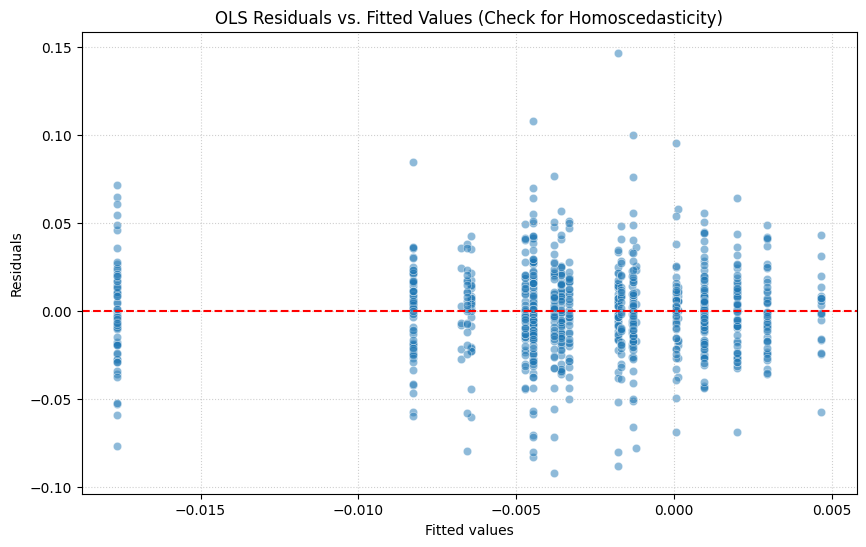

Interpretation of Residuals vs. Fitted Values Plot (OLS):
- Look for a random scatter of points around the horizontal red line (y=0).
- If the spread of residuals changes across different fitted values (which correspond to different industry group means), it suggests heteroscedasticity (non-constant variance).
------------------------------


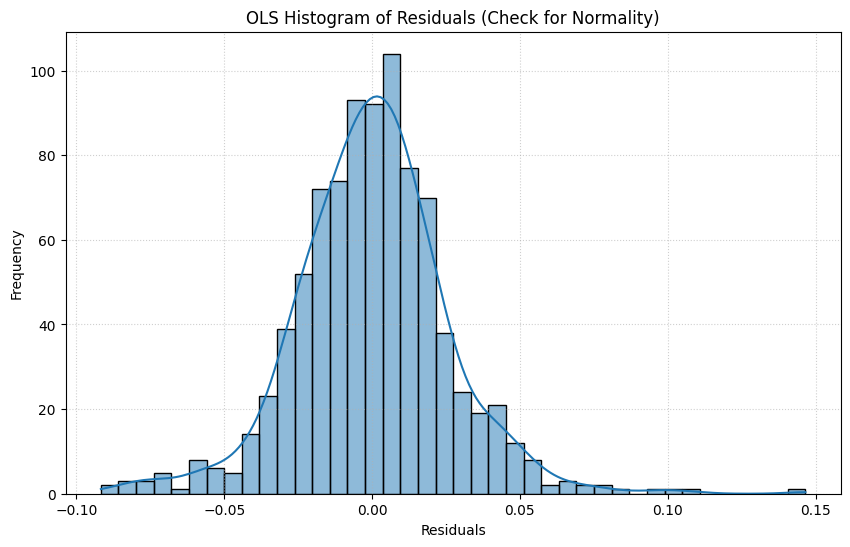

Interpretation of Histogram of Residuals Plot (OLS):
- The histogram should ideally look like a bell curve (normal distribution).
- Significant deviations suggest non-normality.
------------------------------


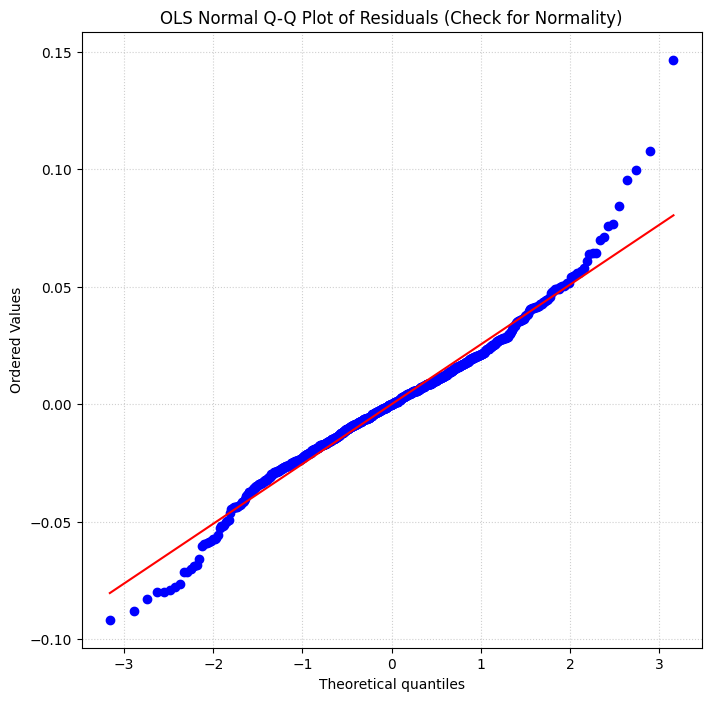

Interpretation of Normal Q-Q Plot of Residuals (OLS):
- The points should ideally fall along the straight diagonal line.
- Deviations indicate departures from normality.
------------------------------


In [4]:
# --- 1. Calculate Average Cosine Similarity per Job per Prompt ---

print("Calculating average cosine similarity per job per prompt...")

# Group by Job ID ('code') and Prompt Type ('prompt') and calculate the mean cosine similarity
avg_cos_sim = df_model.groupby(['code', 'prompt'])['cos_sim_std'].mean().reset_index()

# Pivot the table to have benchmark and persona means in separate columns for each job
avg_cos_sim_pivot = avg_cos_sim.pivot(index='code', columns='prompt', values='cos_sim_std').reset_index()

# Rename columns for clarity
avg_cos_sim_pivot.columns.name = None
avg_cos_sim_pivot = avg_cos_sim_pivot.rename(columns={'benchmark': 'avg_cos_sim_benchmark', 'persona': 'avg_cos_sim_persona'})

# --- 2. Calculate the Difference Score per Job ---

avg_cos_sim_pivot['diff_cos_sim'] = avg_cos_sim_pivot['avg_cos_sim_persona'] - avg_cos_sim_pivot['avg_cos_sim_benchmark']

print("Difference scores calculated.")
print(avg_cos_sim_pivot.head())

# --- Get Industry information for each job ---
# We need the industry for each job to use it as a predictor.
# We can get this from the original df_model, making sure to get a unique industry for each code.
job_industry_map = df_model[['code', 'industry']].drop_duplicates().set_index('code')

# Merge the difference scores with the industry information
df_diff = avg_cos_sim_pivot.set_index('code').join(job_industry_map).reset_index()

# Ensure industry is treated as a categorical variable
df_diff['industry'] = df_diff['industry'].astype('category')


# --- 3. Fit a Standard Linear Regression Model on the Difference Score ---
df_diff['industry'] = df_diff['industry'].astype(str)

# Calculate the overall average difference score
overall_avg_diff = df_diff['diff_cos_sim'].mean()
print(f"Overall average difference score: {overall_avg_diff:.4f}")

# Calculate the average difference score for each industry
industry_avg_diff = df_diff.groupby('industry')['diff_cos_sim'].mean()
print("\nAverage difference score by industry:")
print(industry_avg_diff)

# Find the industry whose average is closest to the overall average
# Calculate the absolute difference between each industry average and the overall average
diff_from_overall_avg = (industry_avg_diff - overall_avg_diff).abs()

# Find the industry with the minimum absolute difference
reference_industry_code = diff_from_overall_avg.idxmin()
print(f"\nIndustry with average closest to overall average: {reference_industry_code}")


print(f"\nRe-fitting OLS Regression with Industry {reference_industry_code} explicitly set as the reference...")
try:
    # Model formula using an f-string to insert the reference_industry_code
    # The variable {reference_industry_code} is inserted into the string.
    # Double quotes around the variable inside the Treatment() call are part of the Patsy syntax
    formula_string = f'diff_cos_sim ~ C(industry, Treatment(reference="{reference_industry_code}"))'
    print(f"Using formula: {formula_string}")

    ols_model_fit = smf.ols(
        formula_string, # Use the dynamically created formula string
        data=df_diff
    ).fit()

    print("\nOLS Regression Results (Explicit Reference Set):")
    print(ols_model_fit.summary())

    # --- 4. Check Assumptions of the Linear Regression Model ---

    print("\nGenerating assumption check plots for Linear Regression on difference scores...")

    # Fitted values from the OLS model
    ols_fitted_values = ols_model_fit.fittedvalues

    # Residuals from the OLS model
    ols_residuals = ols_model_fit.resid

    # Plot 1: Residuals vs. Fitted Values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=ols_fitted_values, y=ols_residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("OLS Residuals vs. Fitted Values (Check for Homoscedasticity)")
    # Linearity is less relevant with categorical predictors for OLS assumptions plots in this form
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    print("Interpretation of Residuals vs. Fitted Values Plot (OLS):")
    print("- Look for a random scatter of points around the horizontal red line (y=0).")
    print("- If the spread of residuals changes across different fitted values (which correspond to different industry group means), it suggests heteroscedasticity (non-constant variance).")
    print("-" * 30)

    # Plot 2: Histogram of Residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(ols_residuals, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("OLS Histogram of Residuals (Check for Normality)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    print("Interpretation of Histogram of Residuals Plot (OLS):")
    print("- The histogram should ideally look like a bell curve (normal distribution).")
    print("- Significant deviations suggest non-normality.")
    print("-" * 30)

    # Plot 3: Normal Q-Q Plot of Residuals
    plt.figure(figsize=(8, 8))
    stats.probplot(ols_residuals, dist="norm", plot=plt)
    plt.title("OLS Normal Q-Q Plot of Residuals (Check for Normality)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()#+
    #
    print("Interpretation of Normal Q-Q Plot of Residuals (OLS):")
    print("- The points should ideally fall along the straight diagonal line.")
    print("- Deviations indicate departures from normality.")
    print("-" * 30)

except Exception as e:
    print(f"\nAn error occurred during analysis: {e}")
    print("Please ensure statsmodels, pandas, matplotlib, seaborn, and scipy are installed.")
    print("Check column names and data structure.")

Overall average difference score: -0.0033

Average difference score by zone:
zone
1   -0.000716
2   -0.003713
3   -0.003562
4   -0.000652
5   -0.006447
Name: diff_cos_sim, dtype: float64

zone with average closest to overall average: 3

Re-fitting OLS Regression with zone 3 explicitly set as the reference...
Using formula: diff_cos_sim ~ C(zone, Treatment(reference="3"))

OLS Regression Results (Explicit Reference Set):
                            OLS Regression Results                            
Dep. Variable:           diff_cos_sim   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.162
Date:                Wed, 21 May 2025   Prob (F-statistic):              0.326
Time:                        23:06:00   Log-Likelihood:                 1957.3
No. Observations:                 879   AIC:                            -3905.
Df Residuals:          

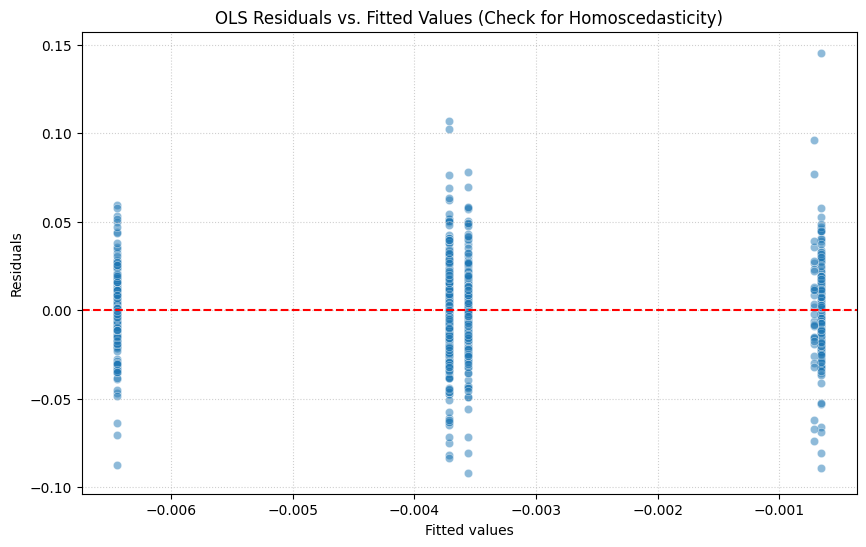

Interpretation of Residuals vs. Fitted Values Plot (OLS):
- Look for a random scatter of points around the horizontal red line (y=0).
- If the spread of residuals changes across different fitted values (which correspond to different zone group means), it suggests heteroscedasticity (non-constant variance).
------------------------------


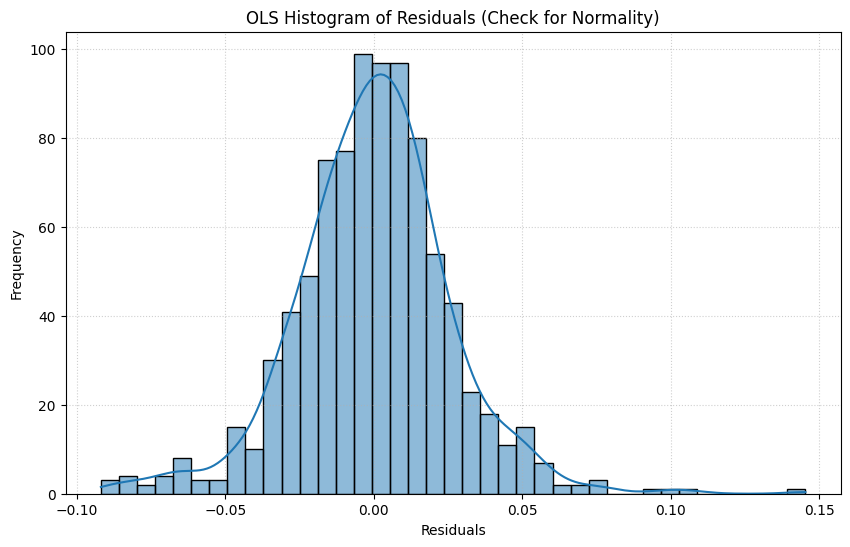

Interpretation of Histogram of Residuals Plot (OLS):
- The histogram should ideally look like a bell curve (normal distribution).
- Significant deviations suggest non-normality.
------------------------------


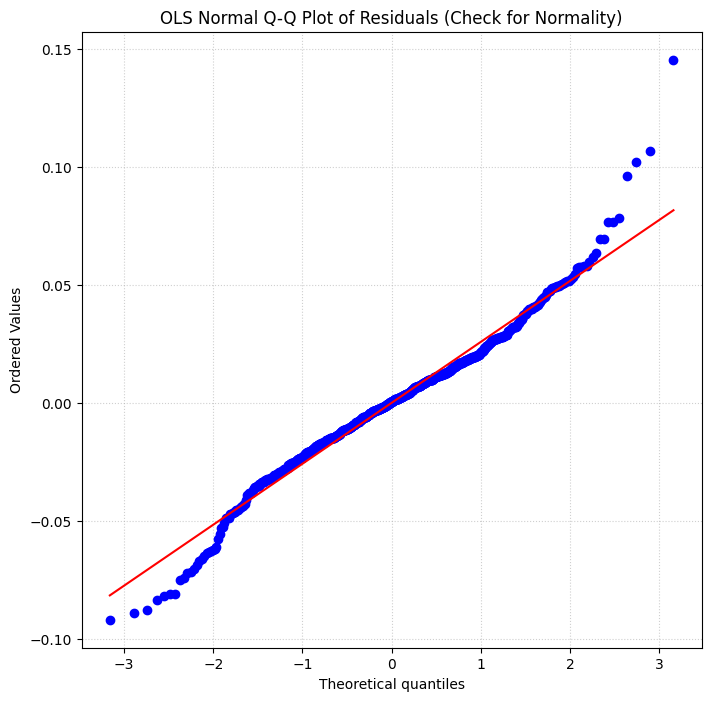

Interpretation of Normal Q-Q Plot of Residuals (OLS):
- The points should ideally fall along the straight diagonal line.
- Deviations indicate departures from normality.
------------------------------


In [5]:
# --- Get zone information for each job ---
# We need the zone for each job to use it as a predictor.
# We can get this from the original df_model, making sure to get a unique zone for each code.
job_zone_map = df_model[['code', 'zone']].drop_duplicates().set_index('code')

# Merge the difference scores with the zone information
df_diff = avg_cos_sim_pivot.set_index('code').join(job_zone_map).reset_index()

# Ensure zone is treated as a categorical variable
df_diff['zone'] = df_diff['zone'].astype('category')


# --- 3. Fit a Standard Linear Regression Model on the Difference Score ---
df_diff['zone'] = df_diff['zone'].astype(str)

# Calculate the overall average difference score
overall_avg_diff = df_diff['diff_cos_sim'].mean()
print(f"Overall average difference score: {overall_avg_diff:.4f}")

# Calculate the average difference score for each zone
zone_avg_diff = df_diff.groupby('zone')['diff_cos_sim'].mean()
print("\nAverage difference score by zone:")
print(zone_avg_diff)

# Find the zone whose average is closest to the overall average
# Calculate the absolute difference between each zone average and the overall average
diff_from_overall_avg = (zone_avg_diff - overall_avg_diff).abs()

# Find the zone with the minimum absolute difference
reference_zone_code = diff_from_overall_avg.idxmin()
print(f"\nzone with average closest to overall average: {reference_zone_code}")


print(f"\nRe-fitting OLS Regression with zone {reference_zone_code} explicitly set as the reference...")
try:
    # Model formula using an f-string to insert the reference_zone_code
    # The variable {reference_zone_code} is inserted into the string.
    # Double quotes around the variable inside the Treatment() call are part of the Patsy syntax
    formula_string = f'diff_cos_sim ~ C(zone, Treatment(reference="{reference_zone_code}"))'
    print(f"Using formula: {formula_string}")

    ols_model_fit = smf.ols(
        formula_string, # Use the dynamically created formula string
        data=df_diff
    ).fit()

    print("\nOLS Regression Results (Explicit Reference Set):")
    print(ols_model_fit.summary())

    # --- 4. Check Assumptions of the Linear Regression Model ---

    print("\nGenerating assumption check plots for Linear Regression on difference scores...")

    # Fitted values from the OLS model
    ols_fitted_values = ols_model_fit.fittedvalues

    # Residuals from the OLS model
    ols_residuals = ols_model_fit.resid

    # Plot 1: Residuals vs. Fitted Values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=ols_fitted_values, y=ols_residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("OLS Residuals vs. Fitted Values (Check for Homoscedasticity)")
    # Linearity is less relevant with categorical predictors for OLS assumptions plots in this form
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    print("Interpretation of Residuals vs. Fitted Values Plot (OLS):")
    print("- Look for a random scatter of points around the horizontal red line (y=0).")
    print("- If the spread of residuals changes across different fitted values (which correspond to different zone group means), it suggests heteroscedasticity (non-constant variance).")
    print("-" * 30)

    # Plot 2: Histogram of Residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(ols_residuals, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("OLS Histogram of Residuals (Check for Normality)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    print("Interpretation of Histogram of Residuals Plot (OLS):")
    print("- The histogram should ideally look like a bell curve (normal distribution).")
    print("- Significant deviations suggest non-normality.")
    print("-" * 30)

    # Plot 3: Normal Q-Q Plot of Residuals
    plt.figure(figsize=(8, 8))
    stats.probplot(ols_residuals, dist="norm", plot=plt)
    plt.title("OLS Normal Q-Q Plot of Residuals (Check for Normality)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()#+
    #
    print("Interpretation of Normal Q-Q Plot of Residuals (OLS):")
    print("- The points should ideally fall along the straight diagonal line.")
    print("- Deviations indicate departures from normality.")
    print("-" * 30)

except Exception as e:
    print(f"\nAn error occurred during analysis: {e}")
    print("Please ensure statsmodels, pandas, matplotlib, seaborn, and scipy are installed.")
    print("Check column names and data structure.")

In [6]:
df[df["title"] == "Actors"]

,title,code,iteration,model,prompt,zone,cos_sim_std,industry
1,Actors,27-2011.00,0,deepseek-r1,benchmark,2,0.598449,27
880,Actors,27-2011.00,1,deepseek-r1,benchmark,2,0.767115,27
1759,Actors,27-2011.00,2,deepseek-r1,benchmark,2,0.759856,27
2638,Actors,27-2011.00,3,deepseek-r1,benchmark,2,0.814135,27
3517,Actors,27-2011.00,4,deepseek-r1,benchmark,2,0.650579,27
...,...,...,...,...,...,...,...,...
66804,Actors,27-2011.00,6,mistral,persona,2,0.740226,27
67683,Actors,27-2011.00,7,mistral,persona,2,0.766439,27
68123,Actors,27-2011.00,0,mistral,persona,2,0.741170,27
69002,Actors,27-2011.00,1,mistral,persona,2,0.785348,27


### Comparing pairwise cosine distance

In [7]:
df = pd.read_json("results/task2/task2_data.json", lines=True)
# --- Step 1: Expand lists to 2D arrays ---
ref_array = np.vstack(df["ref_embeddings"].to_numpy())
gen_array = np.vstack(df["gen_embeddings"].to_numpy())

zone_path = "datasets/job_zone.xlsx"
zone = pd.read_excel(zone_path)
zone = zone[['Title', 'Job Zone']]
zone.columns = ['title', 'zone']
df = df.merge(zone, left_on='title', right_on='title', how='left')
df["industry"] = df["code"].apply(lambda x: x.split("-")[0])
df["industry"] = df["industry"].astype("category")
df["code"] = df["code"].astype("category")
df["zone"] = df["zone"].astype("category")
df["model"] = df["model"].replace("llama 70b", "llama70b")
df["model"] = df["model"].replace("llama 3b", "llama 3b")
df["model"] = df["model"].apply(lambda x: x.split(" ")[0] if " " in x else x)

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, wilcoxon, spearmanr  # Or spearmanr for non-parametric correlation

df_dis = df[df["model"] == "mistral"].copy()
# --- 1. Average the 10 embeddings of each job for Persona and Benchmark ---

# Get unique job codes
unique_codes = df_dis['code'].unique()

# Initialize dictionaries to store average embeddings and single ref embeddings
ref_embeddings_dict = {}
avg_bench_embeddings_dict = {}
avg_pers_embeddings_dict = {}

for code in unique_codes:
    job_df_dis = df_dis[df_dis['code'] == code]
    
    # Reference embeddings (should be the same for all rows of a job, pick one)
    # Ensure it's unique per code, not per row.
    # We take the mean across all occurrences of ref_embeddings for a job, just to be safe.
    ref_embeddings_dict[code] = np.mean(
        np.stack(job_df_dis['ref_embeddings'].values), axis=0
    )

    # Average Benchmark embeddings for this job
    bench_embeddings = np.stack(job_df_dis[job_df_dis['prompt'] == 'benchmark']['gen_embeddings'].values)
    avg_bench_embeddings_dict[code] = np.mean(bench_embeddings, axis=0)

    # Average Persona embeddings for this job
    pers_embeddings = np.stack(job_df_dis[job_df_dis['prompt'] == 'persona']['gen_embeddings'].values)
    avg_pers_embeddings_dict[code] = np.mean(pers_embeddings, axis=0)

# Convert dictionaries to ordered lists of arrays
ref_embs_list = np.array([ref_embeddings_dict[code] for code in unique_codes])
avg_bench_embs_list = np.array([avg_bench_embeddings_dict[code] for code in unique_codes])
avg_pers_embs_list = np.array([avg_pers_embeddings_dict[code] for code in unique_codes])

print(f"Shape of ref_embs_list: {ref_embs_list.shape}")
print(f"Shape of avg_bench_embs_list: {avg_bench_embs_list.shape}")
print(f"Shape of avg_pers_embs_list: {avg_pers_embs_list.shape}")
print("-" * 30)

# --- 2. L2 normalize each of the embeddings ---
# Normalize ensures that vector magnitudes are 1, so cosine similarity is only about angle.
ref_embs_norm = normalize(ref_embs_list)
avg_bench_embs_norm = normalize(avg_bench_embs_list)
avg_pers_embs_norm = normalize(avg_pers_embs_list)

print("Embeddings normalized.")
print("-" * 30)

# --- 3. Calculate cosine distance of each job to each other, for all jobs ---
# pdist calculates pairwise distances between observations in X.
# squareform converts the condensed distance matrix output by pdist into a square matrix.
# We use 'cosine' metric.

D_ref = squareform(pdist(ref_embs_norm, metric='cosine'))
D_bench = squareform(pdist(avg_bench_embs_norm, metric='cosine'))
D_pers = squareform(pdist(avg_pers_embs_norm, metric='cosine'))

print(f"Shape of D_ref (distance matrix): {D_ref.shape}")
print(f"Shape of D_bench (distance matrix): {D_bench.shape}")
print(f"Shape of D_pers (distance matrix): {D_pers.shape}")
print("-" * 30)


# --- 4. Take the upper half (excluding diagonal) and flatten it ---
def get_upper_triangle_flattened(matrix):
    """
    Returns the flattened upper triangle of a square matrix, excluding the diagonal.
    """
    n = matrix.shape[0]
    # np.triu_indices(n, k=1) gets the indices for the upper triangle (k=1 excludes diagonal)
    return matrix[np.triu_indices(n, k=1)]

flat_D_ref = get_upper_triangle_flattened(D_ref)
flat_D_bench = get_upper_triangle_flattened(D_bench)
flat_D_pers = get_upper_triangle_flattened(D_pers)

print(f"Length of flattened D_ref: {len(flat_D_ref)}")
print(f"Length of flattened D_bench: {len(flat_D_bench)}")
print(f"Length of flattened D_pers: {len(flat_D_pers)}")
# print(f"Expected length for {num_jobs} jobs: {num_jobs * (num_jobs - 1) // 2}")
print("-" * 30)


# --- 5. Calculate correlation of Benchmark and Ref, and Persona and Ref ---
# Pearson correlation is a common choice for this, as distances are continuous.
# If you expect non-linear relationships or outliers, Spearman correlation might be an alternative.

corr_bench_ref, _ = spearmanr(flat_D_bench, flat_D_ref)
corr_pers_ref, _ = spearmanr(flat_D_pers, flat_D_ref)

print(f"Correlation (Benchmark vs Ref): {corr_bench_ref:.4f}")
print(f"Correlation (Persona vs Ref): {corr_pers_ref:.4f}")
print("-" * 30)

# --- 6. Directly compare which number is bigger ---
if corr_pers_ref > corr_bench_ref:
    print(f"Persona embeddings show HIGHER structural correlation with Reference ({corr_pers_ref:.4f}) "
          f"than Benchmark embeddings ({corr_bench_ref:.4f}).")
    print("This suggests Persona better replicates the semantic structure of jobs.")
elif corr_pers_ref < corr_bench_ref:
    print(f"Persona embeddings show LOWER structural correlation with Reference ({corr_pers_ref:.4f}) "
          f"than Benchmark embeddings ({corr_bench_ref:.4f}).")
    print("This suggests Benchmark better replicates the semantic structure of jobs.")
else:
    print(f"Persona and Benchmark embeddings show SIMILAR structural correlation with Reference ({corr_pers_ref:.4f}).")

print("-" * 30)

# --- NEW: Calculate Per-Job Structural Similarity & Differences ---
per_job_delta_corr = []
for i in range(879):
    # Get distance profiles for job i (excluding self-distance)
    ref_profile = np.delete(D_ref[i, :], i)
    bench_profile = np.delete(D_bench[i, :], i)
    pers_profile = np.delete(D_pers[i, :], i)
    
    # Calculate per-job correlations
    corr_i_bench = spearmanr(bench_profile, ref_profile)[0]
    corr_i_pers = spearmanr(pers_profile, ref_profile)[0]
    
    # Calculate the difference
    delta_corr_i = corr_i_pers - corr_i_bench
    per_job_delta_corr.append(delta_corr_i)

per_job_delta_corr_array = np.array(per_job_delta_corr)
print(f"Mean of per-job Delta Correlation: {np.mean(per_job_delta_corr_array):.4f}")
print(f"Median of per-job Delta Correlation: {np.median(per_job_delta_corr_array):.4f}")
print("-" * 30)

# --- Statistical Test on Per-Job Differences (Overall significance) ---
# Wilcoxon signed-rank test to see if the median of per_job_delta_corr_array is significantly different from 0.
# We use 'greater' because we hypothesize Persona > Benchmark.

stat, p_value = wilcoxon(per_job_delta_corr_array, alternative='greater')

print("\nStatistical Test on Per-Job Differences (Wilcoxon Signed-Rank Test):")
print(f"Test Statistic (W): {stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05: # Common significance level
    print("The median difference in per-job structural correlations is statistically significant (p < 0.05).")
    if np.median(per_job_delta_corr_array) > 0:
        print("This strongly suggests Persona's structural replication is significantly better than Benchmark's, on average per job.")
    else: # Should not happen with alternative='greater' if p < 0.05
        print("This suggests Benchmark's structural replication is significantly better than Persona's, on average per job.")
else:
    print("The median difference in per-job structural correlations is NOT statistically significant (p >= 0.05).")
    print("We cannot conclude that Persona's structural replication is significantly different from Benchmark's, on average per job.")


Shape of ref_embs_list: (879, 768)
Shape of avg_bench_embs_list: (879, 768)
Shape of avg_pers_embs_list: (879, 768)
------------------------------
Embeddings normalized.
------------------------------
Shape of D_ref (distance matrix): (879, 879)
Shape of D_bench (distance matrix): (879, 879)
Shape of D_pers (distance matrix): (879, 879)
------------------------------
Length of flattened D_ref: 385881
Length of flattened D_bench: 385881
Length of flattened D_pers: 385881
------------------------------
Correlation (Benchmark vs Ref): 0.7434
Correlation (Persona vs Ref): 0.7330
------------------------------
Persona embeddings show LOWER structural correlation with Reference (0.7330) than Benchmark embeddings (0.7434).
This suggests Benchmark better replicates the semantic structure of jobs.
------------------------------
Mean of per-job Delta Correlation: -0.0081
Median of per-job Delta Correlation: -0.0077
------------------------------

Statistical Test on Per-Job Differences (Wilcoxon

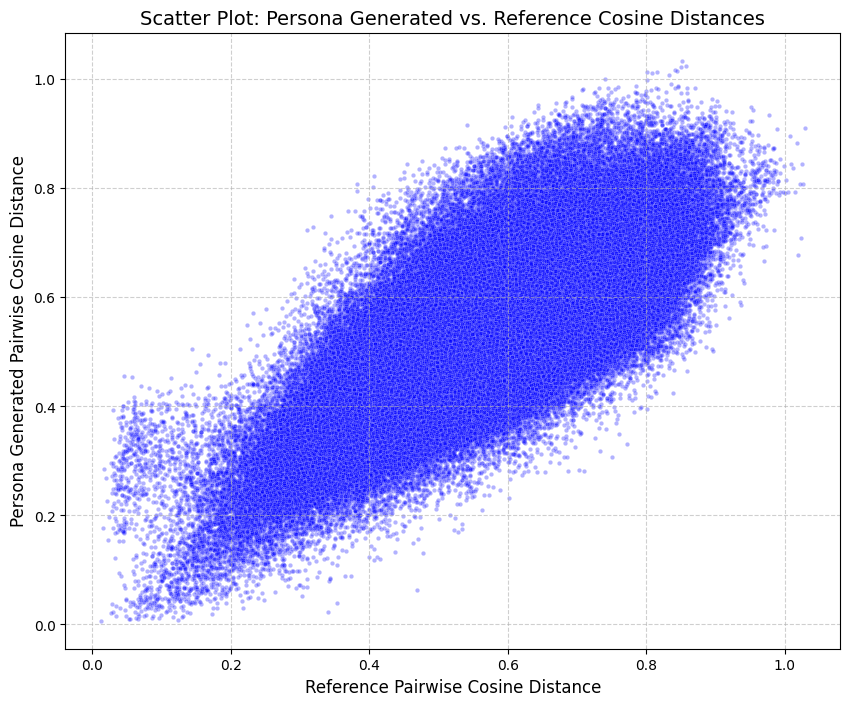

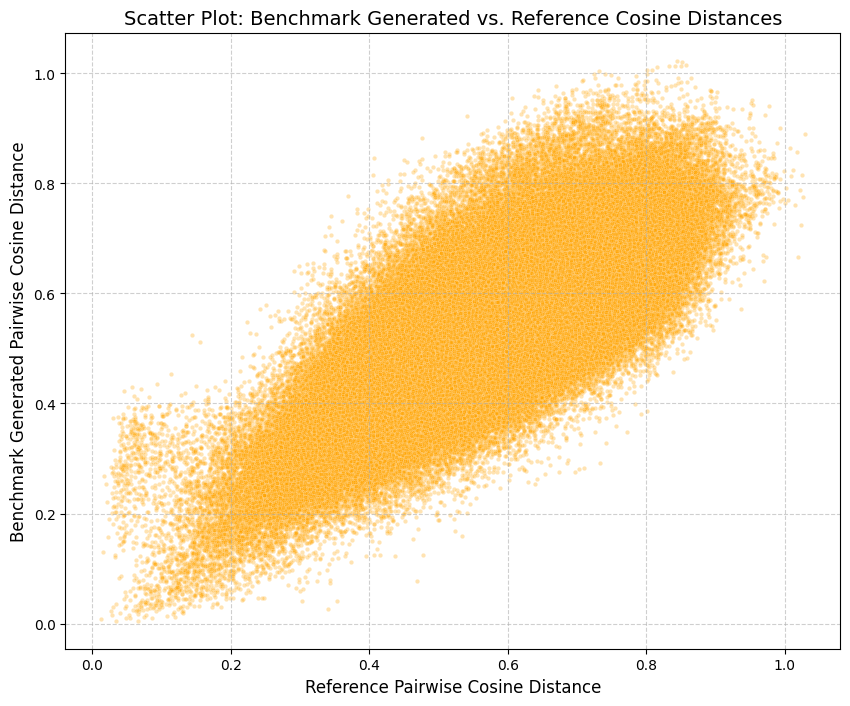

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns # For nicer plots

# Assuming flat_D_ref, flat_D_pers, and flat_D_bench are already computed from your analysis.
# Example: If you ran the code from the previous response, these variables should exist.

# --- Scatter plot for Persona Generated vs. Reference Cosine Distances ---
plt.figure(figsize=(10, 8))
sns.scatterplot(x=flat_D_ref, y=flat_D_pers, alpha=0.3, s=10, color='blue') # alpha for transparency, s for dot size
plt.title('Scatter Plot: Persona Generated vs. Reference Cosine Distances', fontsize=14)
plt.xlabel('Reference Pairwise Cosine Distance', fontsize=12)
plt.ylabel('Persona Generated Pairwise Cosine Distance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Scatter plot for Benchmark Generated vs. Reference Cosine Distances (for comparison) ---
plt.figure(figsize=(10, 8))
sns.scatterplot(x=flat_D_ref, y=flat_D_bench, alpha=0.3, s=10, color='orange')
plt.title('Scatter Plot: Benchmark Generated vs. Reference Cosine Distances', fontsize=14)
plt.xlabel('Reference Pairwise Cosine Distance', fontsize=12)
plt.ylabel('Benchmark Generated Pairwise Cosine Distance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Clustering

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, wilcoxon # Import wilcoxon for the statistical test



df_dis = df[df["model"] == "mistral"].copy()
# --- 1. Average the 10 embeddings of each job for Persona and Benchmark ---
# Group by code first, then aggregate ref_embeddings.
# For gen_embeddings, group by code and prompt, then average.
# Ensure 'industry' and 'zone' are carried through correctly.

# Get unique job codes along with their industry and zone
unique_job_metadata = df_dis[['code', 'industry', 'zone']].drop_duplicates().set_index('code')

# Average reference embeddings
ref_embeddings_grouped = df.groupby('code')['ref_embeddings'].apply(lambda x: np.mean(np.stack(x), axis=0)).to_dict()

# Average generated embeddings for benchmark and persona
avg_bench_embeddings_grouped = df_dis[df_dis['prompt'] == 'benchmark'].groupby('code')['gen_embeddings'].apply(lambda x: np.mean(np.stack(x), axis=0)).to_dict()
avg_pers_embeddings_grouped = df_dis[df_dis['prompt'] == 'persona'].groupby('code')['gen_embeddings'].apply(lambda x: np.mean(np.stack(x), axis=0)).to_dict()

# Create ordered lists of embeddings and their metadata for distance calculation
codes_ordered = unique_job_metadata.index.tolist()
ref_embs_list = np.array([ref_embeddings_grouped[code] for code in codes_ordered])
avg_bench_embs_list = np.array([avg_bench_embeddings_grouped[code] for code in codes_ordered])
avg_pers_embs_list = np.array([avg_pers_embeddings_grouped[code] for code in codes_ordered])


# --- 2. L2 normalize each of the embeddings ---
ref_embs_norm = normalize(ref_embs_list)
avg_bench_embs_norm = normalize(avg_bench_embs_list)
avg_pers_embs_norm = normalize(avg_pers_embs_list)


# --- 3. Calculate cosine distance of each job to each other, for all jobs ---
D_ref = squareform(pdist(ref_embs_norm, metric='cosine'))
D_bench = squareform(pdist(avg_bench_embs_norm, metric='cosine'))
D_pers = squareform(pdist(avg_pers_embs_norm, metric='cosine'))


# --- 4. Take the upper half (excluding diagonal) and flatten it ---
def get_upper_triangle_flattened(matrix):
    n = matrix.shape[0]
    return matrix[np.triu_indices(n, k=1)]

flat_D_ref = get_upper_triangle_flattened(D_ref)
flat_D_bench = get_upper_triangle_flattened(D_bench)
flat_D_pers = get_upper_triangle_flattened(D_pers)


# --- 5. Calculate overall correlation of Benchmark and Ref, and Persona and Ref ---
# Note: pearsonr returns (correlation_coefficient, p_value)
corr_bench_ref = pearsonr(flat_D_bench, flat_D_ref)[0]
corr_pers_ref = pearsonr(flat_D_pers, flat_D_ref)[0]

print(f"Overall Correlation (Benchmark vs Ref): {corr_bench_ref:.4f}")
print(f"Overall Correlation (Persona vs Ref): {corr_pers_ref:.4f}")
print("-" * 30)

# --- 6. Directly compare which number is bigger (overall) ---
if corr_pers_ref > corr_bench_ref:
    print(f"Persona embeddings show HIGHER overall structural correlation with Reference ({corr_pers_ref:.4f}) "
          f"than Benchmark embeddings ({corr_bench_ref:.4f}).")
    print("This suggests Persona generally better replicates the semantic structure of jobs.")
elif corr_pers_ref < corr_bench_ref:
    print(f"Persona embeddings show LOWER overall structural correlation with Reference ({corr_pers_ref:.4f}) "
          f"than Benchmark embeddings ({corr_bench_ref:.4f}).")
    print("This suggests Benchmark generally better replicates the semantic structure of jobs.")
else:
    print(f"Persona and Benchmark embeddings show SIMILAR overall structural correlation with Reference ({corr_pers_ref:.4f}).")

print("-" * 30)

# --- NEW: Calculate Per-Job Structural Similarity & Differences for Combined Groups ---
# Stores per-job delta correlations categorized by their combined group
per_combined_group_delta_corrs = {group: [] for group in unique_job_metadata.apply(lambda x: f"{x['industry']} - {x['zone']}", axis=1).unique()}

for i, code_i in enumerate(codes_ordered):
    # Get distance profiles for code_i (excluding self-distance and distance to code_i itself)
    # The `np.delete` removes the row `i` from the distance matrices D_ref, D_bench, D_pers
    # so that the profiles compare code_i against all *other* job codes.
    ref_profile = np.delete(D_ref[i, :], i)
    bench_profile = np.delete(D_bench[i, :], i)
    pers_profile = np.delete(D_pers[i, :], i)
    
    # Calculate per-job correlations
    # Ensure there's enough variation for Pearson correlation
    # Pearsonr returns (correlation_coefficient, p_value)
    corr_i_bench = np.nan
    corr_i_pers = np.nan

    if np.std(ref_profile) > 1e-9 and np.std(bench_profile) > 1e-9: # Check for non-zero standard deviation
        corr_i_bench = pearsonr(bench_profile, ref_profile)[0]
    
    if np.std(ref_profile) > 1e-9 and np.std(pers_profile) > 1e-9:
        corr_i_pers = pearsonr(pers_profile, ref_profile)[0]
    
    # Calculate the difference if both correlations are valid
    delta_corr_i = np.nan
    if not np.isnan(corr_i_pers) and not np.isnan(corr_i_bench):
        delta_corr_i = corr_i_pers - corr_i_bench
    
    # Get the combined group for this code
    industry = unique_job_metadata.loc[code_i]['industry']
    zone = unique_job_metadata.loc[code_i]['zone']
    combined_group = f"{industry} - {zone}"
    
    # Store the delta correlation in the appropriate group
    if not np.isnan(delta_corr_i):
        per_combined_group_delta_corrs[combined_group].append(delta_corr_i)

# --- Overall Statistical Test on Per-Job Differences ---
# Flatten all delta correlations for an overall test
all_delta_corrs = [val for sublist in per_combined_group_delta_corrs.values() for val in sublist]

if len(all_delta_corrs) > 1:
    stat, p_value = wilcoxon(all_delta_corrs, alternative='two-sided', nan_policy='omit')

    print("\n--- Overall Statistical Test on Per-Job Delta Correlations (Wilcoxon Signed-Rank Test) ---")
    print(f"Test Statistic (W): {stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05: # Common significance level
        print("The median difference in per-job structural correlations is statistically significant (p < 0.05).")
        if np.median(all_delta_corrs) > 0:
            print("This suggests Persona's structural replication is significantly better than Benchmark's, on average per job.")
        else:
            print("This suggests Benchmark's structural replication is significantly better than Persona's, on average per job.")
    else:
        print("The median difference in per-job structural correlations is NOT statistically significant (p >= 0.05).")
        print("We cannot conclude a significant difference in structural replication, on average per job.")
else:
    print("\nNot enough valid per-job delta correlations for overall statistical test.")

print("-" * 30)


# --- Per-Combined-Group Structural Similarity Results ---
print("\n--- Per-Combined-Group Structural Similarity Results ---")
per_group_structural_results = []
sorted_combined_groups = sorted(per_combined_group_delta_corrs.keys())

for group_name in sorted_combined_groups:
    delta_corrs_in_group = np.array(per_combined_group_delta_corrs[group_name])
    
    mean_delta = np.nan
    median_delta = np.nan
    std_delta = np.nan
    p_val_wilcoxon = np.nan
    significance = "Not Applicable"
    better_model = "N/A"

    # Only perform stats if there's enough data in the group
    # Wilcoxon needs at least 2 non-zero differences, but ideally more for robust results
    if len(delta_corrs_in_group[~np.isnan(delta_corrs_in_group)]) > 1:
        mean_delta = np.nanmean(delta_corrs_in_group)
        median_delta = np.nanmedian(delta_corrs_in_group)
        std_delta = np.nanstd(delta_corrs_in_group)
        
        # Perform two-sided Wilcoxon test on the delta correlations
        try:
            stat_g, p_val_wilcoxon = wilcoxon(delta_corrs_in_group, alternative='two-sided', nan_policy='omit')
            
            if p_val_wilcoxon < 0.001:
                significance = "Highly Significant (p < 0.001)"
            elif p_val_wilcoxon < 0.01:
                significance = "Very Significant (p < 0.01)"
            elif p_val_wilcoxon < 0.05:
                significance = "Significant (p < 0.05)"
            elif p_val_wilcoxon < 0.1:
                significance = "Marginally Significant (p < 0.1)"
            else:
                significance = "Not Significant"

            if p_val_wilcoxon < 0.1: # Determine direction if at least marginally significant
                if median_delta > 0:
                    better_model = "Persona"
                else:
                    better_model = "Benchmark"
            else:
                better_model = "No significant difference"
        except ValueError as e:
            # Handle cases where Wilcoxon can't run (e.g., all differences are zero)
            p_val_wilcoxon = np.nan
            significance = f"Wilcoxon Error: {e}"
            better_model = "N/A (check data)"
    else:
        significance = "Not enough data for test"
        better_model = "N/A"


    per_group_structural_results.append({
        'Combined Group': group_name,
        'Mean Delta Corr (Persona - Bench)': mean_delta,
        'Median Delta Corr (Persona - Bench)': median_delta,
        'Std Dev Delta Corr': std_delta,
        'Wilcoxon p-value': p_val_wilcoxon,
        'Significance': significance,
        'Better Model': better_model
    })

per_group_structural_df = pd.DataFrame(per_group_structural_results)
print(per_group_structural_df.round(4).to_string()) # Use to_string() to display all rows/columns

C:\Users\godfr\AppData\Local\Temp\ipykernel_10644\3984017015.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ref_embeddings_grouped = df.groupby('code')['ref_embeddings'].apply(lambda x: np.mean(np.stack(x), axis=0)).to_dict()
C:\Users\godfr\AppData\Local\Temp\ipykernel_10644\3984017015.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_bench_embeddings_grouped = df_dis[df_dis['prompt'] == 'benchmark'].groupby('code')['gen_embeddings'].apply(lambda x: np.mean(np.stack(x), axis=0)).to_dict()
C:\Users\godfr\AppData\Local\Temp\ipykernel_10644\3984017015.py:23: FutureWarning: The default of observed=Fa

Overall Correlation (Benchmark vs Ref): 0.7636
Overall Correlation (Persona vs Ref): 0.7530
------------------------------
Persona embeddings show LOWER overall structural correlation with Reference (0.7530) than Benchmark embeddings (0.7636).
This suggests Benchmark generally better replicates the semantic structure of jobs.
------------------------------

--- Overall Statistical Test on Per-Job Delta Correlations (Wilcoxon Signed-Rank Test) ---
Test Statistic (W): 68769.0000
P-value: 0.0000
The median difference in per-job structural correlations is statistically significant (p < 0.05).
This suggests Benchmark's structural replication is significantly better than Persona's, on average per job.
------------------------------

--- Per-Combined-Group Structural Similarity Results ---
   Combined Group  Mean Delta Corr (Persona - Bench)  Median Delta Corr (Persona - Bench)  Std Dev Delta Corr  Wilcoxon p-value                      Significance               Better Model
0          11 - 2

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import umap

df_clus = df[df["model"] == "deepseek-r1"].copy()

# --- 1. Prepare All Normalized Embeddings ---

# Get unique reference embeddings (one per code)
# Ensure no duplicates if code appears multiple times but ref_embeddings are identical.
ref_embeddings_df = df_clus.drop_duplicates(subset=['code']).set_index('code')
ref_embs_list = np.stack(ref_embeddings_df['ref_embeddings'].values)
ref_embs_norm = normalize(ref_embs_list)

# Get ALL generated embeddings (10 per code for each prompt type)
all_bench_embs = np.stack(df_clus[df_clus['prompt'] == 'benchmark']['gen_embeddings'].values)
all_pers_embs = np.stack(df_clus[df_clus['prompt'] == 'persona']['gen_embeddings'].values)

# Normalize all generated embeddings
all_bench_embs_norm = normalize(all_bench_embs)
all_pers_embs_norm = normalize(all_pers_embs)

print(f"Shape of normalized Ref embeddings: {ref_embs_norm.shape}")
print(f"Shape of normalized ALL Benchmark embeddings: {all_bench_embs_norm.shape}")
print(f"Shape of normalized ALL Persona embeddings: {all_pers_embs_norm.shape}")
print("-" * 30)

# reduce dimensionality of the embeddings using UMAP
n_components = 15
k_clusters = 20 # You can experiment with different k values
reducer = umap.UMAP(n_components=n_components,
                     n_neighbors=15, # Tune this
                     min_dist=0,   # Tune this
                     metric='cosine', # Or 'euclidean' if preferred, but cosine is good for normalized vecs
                     random_state=42)

# Fit UMAP ONLY on the Reference embeddings (gold standard)
print("Fitting UMAP on Reference embeddings...")
reducer.fit(ref_embs_norm)
print("UMAP fitting complete.")

# Transform all sets of embeddings using the fitted UMAP model
ref_embs_reduced = reducer.transform(ref_embs_norm)
all_bench_embs_reduced = reducer.transform(all_bench_embs_norm)
all_pers_embs_reduced = reducer.transform(all_pers_embs_norm)

# --- 2. Define Reference Clusters (Gold Standard) ---
# Choose k, the number of clusters. This defines the granularity of your semantic groups.
# A common starting point is sqrt(N) or based on domain knowledge.
# For 879 jobs, k=50 or k=100 might be reasonable.


# Initialize KMeans. Using random_state for reproducibility.
# n_init='auto' (default in recent scikit-learn) or n_init=10
# For cosine similarity with KMeans, ensure vectors are L2-normalized beforehand.
kmeans_ref = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')

# Fit KMeans on the Reference embeddings
kmeans_ref.fit(ref_embs_reduced)
ref_cluster_labels = kmeans_ref.labels_

print(f"KMeans fitted on Reference data with k={k_clusters} clusters.")
print("-" * 30)


# --- 3. Map Job Codes to Reference Clusters ---
# Create a mapping from code to its cluster label
code_to_ref_cluster = {}
for i, code in enumerate(ref_embeddings_df.index):
    code_to_ref_cluster[code] = ref_cluster_labels[i]

print("Job codes mapped to their Reference cluster labels.")
print("-" * 30)


# --- 4. Create "Ground Truth" Labels for Generated Data ---
# These are the "true" cluster labels for each generated embedding,
# based on which Reference cluster its code belongs to.

true_labels_bench = []
for code in df_clus[df_clus['prompt'] == 'benchmark']['code']:
    true_labels_bench.append(code_to_ref_cluster[code])

true_labels_pers = []
for code in df_clus[df_clus['prompt'] == 'persona']['code']:
    true_labels_pers.append(code_to_ref_cluster[code])

true_labels_bench = np.array(true_labels_bench)
true_labels_pers = np.array(true_labels_pers)

print(f"Shape of ground truth labels for Benchmark: {true_labels_bench.shape}")
print(f"Shape of ground truth labels for Persona: {true_labels_pers.shape}")
print("-" * 30)


# --- 5. Predict Clusters for Generated Data (using Reference KMeans Model) ---
# We use the *same* KMeans model that was fitted on the Reference data
# to predict where the generated embeddings would fall within those defined clusters.

predicted_labels_bench = kmeans_ref.predict(all_bench_embs_reduced)
predicted_labels_pers = kmeans_ref.predict(all_pers_embs_reduced)

print("Predicted cluster labels for generated data.")
print("-" * 30)


# --- 6. Calculate Adjusted Rand Index (ARI) ---
# ARI measures the similarity of the two assignments,
# ignoring permutations and chance agreement.
# A score of 1.0 means perfect match. A score near 0 means random assignment.

ari_bench = adjusted_rand_score(true_labels_bench, predicted_labels_bench)
ari_pers = adjusted_rand_score(true_labels_pers, predicted_labels_pers)

print(f"Adjusted Rand Index (ARI) for Benchmark vs Reference structure: {ari_bench:.4f}")
print(f"Adjusted Rand Index (ARI) for Persona vs Reference structure: {ari_pers:.4f}")
print("-" * 30)


# --- 7. Compare ARI Scores ---
if ari_pers > ari_bench:
    print(f"Persona embeddings ({ari_pers:.4f}) show HIGHER structural alignment with Reference "
          f"than Benchmark embeddings ({ari_bench:.4f}).")
    print(f"This suggests Persona better preserves the semantic grouping structure defined by the Reference data at k={k_clusters}.")
elif ari_pers < ari_bench:
    print(f"Persona embeddings ({ari_pers:.4f}) show LOWER structural alignment with Reference "
          f"than Benchmark embeddings ({ari_bench:.4f}).")
    print(f"This suggests Benchmark better preserves the semantic grouping structure at k={k_clusters}.")
else:
    print(f"Persona and Benchmark embeddings show SIMILAR structural alignment with Reference at k={k_clusters}.")

Shape of normalized Ref embeddings: (879, 768)
Shape of normalized ALL Benchmark embeddings: (8790, 768)
Shape of normalized ALL Persona embeddings: (8790, 768)
------------------------------
Fitting UMAP on Reference embeddings...


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP fitting complete.
KMeans fitted on Reference data with k=20 clusters.
------------------------------
Job codes mapped to their Reference cluster labels.
------------------------------
Shape of ground truth labels for Benchmark: (8790,)
Shape of ground truth labels for Persona: (8790,)
------------------------------
Predicted cluster labels for generated data.
------------------------------
Adjusted Rand Index (ARI) for Benchmark vs Reference structure: 0.6707
Adjusted Rand Index (ARI) for Persona vs Reference structure: 0.6819
------------------------------
Persona embeddings (0.6819) show HIGHER structural alignment with Reference than Benchmark embeddings (0.6707).
This suggests Persona better preserves the semantic grouping structure defined by the Reference data at k=20.


Fitting UMAP on Reference embeddings...


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP fitting complete.
Shape of UMAP-reduced Ref embeddings: (879, 20)
------------------------------
Finding optimal k for Reference Embeddings...

Optimal k by Silhouette Score: 42 (Score: 0.5798)
------------------------------


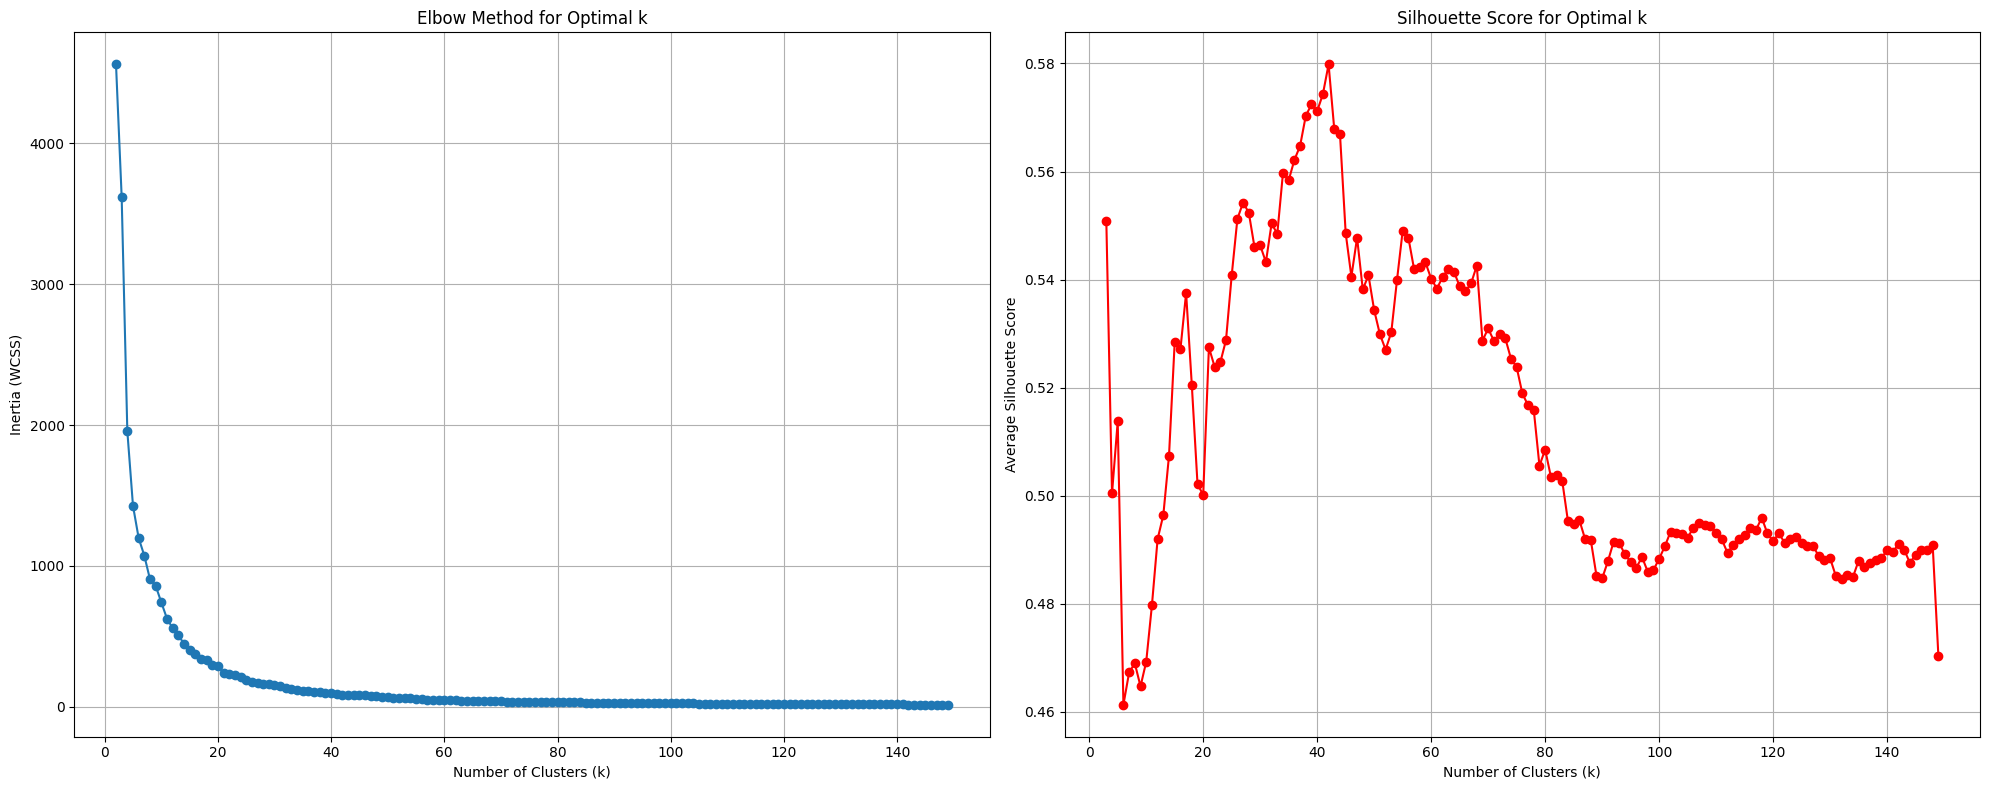

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score # Import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA # Import PCA
import umap # Import UMAP

# --- 1. Prepare All Normalized Embeddings ---
ref_embeddings_df = df_clus.drop_duplicates(subset=['code']).set_index('code')
ref_embs_list = np.stack(ref_embeddings_df['ref_embeddings'].values)
ref_embs_norm = normalize(ref_embs_list)

# # --- 2. Perform Dimension Reduction using PCA ---
# # Choose the number of components.
# # You can choose a fixed number (e.g., 50, 100) or a fraction of variance to explain (e.g., 0.95 for 95%).
# n_components = 20 # Example: reduce to 50 dimensions. Adjust as needed.

# pca = PCA(n_components=n_components, random_state=42)

# # Fit PCA ONLY on the Reference embeddings (gold standard)
# pca.fit(ref_embs_norm)

# # Transform all sets of embeddings using the fitted PCA model
# ref_embs_reduced = pca.transform(ref_embs_norm)
# all_bench_embs_reduced = pca.transform(all_bench_embs_norm)
# all_pers_embs_reduced = pca.transform(all_pers_embs_norm)

# print(f"PCA fitted, capturing {pca.explained_variance_ratio_.sum():.2%} of variance.")
# print(f"Shape of Reduced Ref embeddings: {ref_embs_reduced.shape}")
# print(f"Shape of Reduced ALL Benchmark embeddings: {all_bench_embs_reduced.shape}")
# print(f"Shape of Reduced ALL Persona embeddings: {all_pers_embs_reduced.shape}")
# print("-" * 30)

# --- 2. Perform Dimension Reduction using UMAP ---
# Choose the number of components.
# Common values for visualization are 2 or 3. For clustering, you might go higher (e.g., 10, 20, 50).
 # Example: reduce to 50 dimensions. Adjust as needed.

# UMAP specific parameters:
# n_neighbors: Controls how UMAP balances local vs. global structure.
#    Smaller values emphasize local structure, larger values emphasize global structure.
#    Common values are 15-200. Default is 15.
# min_dist: Controls how tightly points are allowed to pack together.
#    Smaller values mean tighter clusters. Default is 0.1.
# metric: The distance metric to use. 'cosine' is good for normalized embeddings.
n_components = 20
reducer = umap.UMAP(n_components=n_components,
                     n_neighbors=15, # Tune this
                     min_dist=0.0,   # Tune this
                     metric='cosine', # Or 'euclidean' if preferred, but cosine is good for normalized vecs
                     random_state=42)

# Fit UMAP ONLY on the Reference embeddings (gold standard)
print("Fitting UMAP on Reference embeddings...")
reducer.fit(ref_embs_norm)
print("UMAP fitting complete.")

# Transform all sets of embeddings using the fitted UMAP model
ref_embs_reduced = reducer.transform(ref_embs_norm)
# all_bench_embs_reduced = reducer.transform(all_bench_embs_norm)
# all_pers_embs_reduced = reducer.transform(all_pers_embs_norm)

print(f"Shape of UMAP-reduced Ref embeddings: {ref_embs_reduced.shape}")
# print(f"Shape of UMAP-reduced ALL Benchmark embeddings: {all_bench_embs_reduced.shape}")
# print(f"Shape of UMAP-reduced ALL Persona embeddings: {all_pers_embs_reduced.shape}")
print("-" * 30)



# --- Find Optimal k for Reference Embeddings ---
print("Finding optimal k for Reference Embeddings...")

# Define a range of k values to test
k_range = range(2, min(300, 150)) # Test up to num_jobs or a reasonable upper bound

inertia_values = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(ref_embs_reduced)
    ref_cluster_labels_plot = kmeans.labels_


    # --- 5. Map Job Codes to Reference Clusters (for ground truth labels) ---
    code_to_ref_cluster = {}
    for i, code in enumerate(ref_embeddings_df.index):
        code_to_ref_cluster[code] = ref_cluster_labels_plot[i]
    
    # Store inertia (WCSS)
    inertia_values.append(kmeans.inertia_)
    
    # Calculate Silhouette Score (only if k > 1)
    if k > 1:
        score = silhouette_score(ref_embs_reduced, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan) # Placeholder for k=1, where silhouette is undefined


# Find k with highest Silhouette Score (excluding NaN for k=1)
if len(silhouette_scores) > 1:
    best_k_silhouette = k_range[np.nanargmax(silhouette_scores)]
    print(f"\nOptimal k by Silhouette Score: {best_k_silhouette} (Score: {np.nanmax(silhouette_scores):.4f})")
else:
    print("\nNot enough k values to calculate meaningful Silhouette Scores.")

print("-" * 30)

# --- Plotting Elbow Method ---
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)

# --- Plotting Silhouette Scores ---
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
# Adjust k_range for silhouette scores since it starts from k=2
plt.plot(list(k_range)[1:], silhouette_scores[1:], marker='o', color='red') 
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


Fitting UMAP on Reference embeddings for 2D plot (n_components=2)...


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clustering performed for visualization with k=20.
------------------------------
Length of true_labels_bench_plot: 8790
Length of predicted_labels_bench_plot: 8790
Length of true_labels_pers_plot: 8790
Length of predicted_labels_pers_plot: 8790
------------------------------


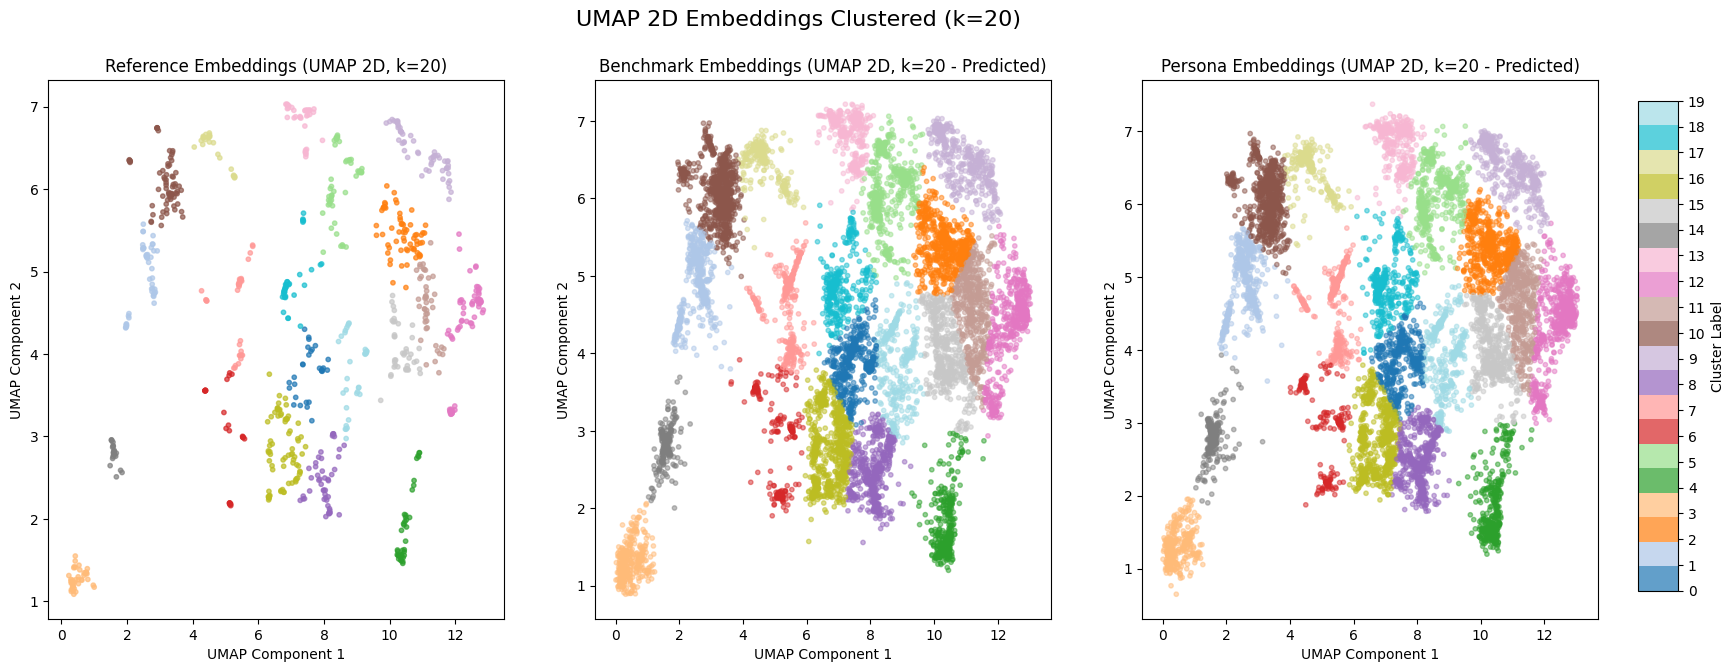


2D UMAP plots generated. Observe how well Benchmark and Persona embeddings align with the Reference clusters.
The tighter and more distinct the groups in the Benchmark/Persona plots, the better the semantic structure is preserved.
------------------------------
ARI (2D UMAP, k=20) - Benchmark: 0.6408
ARI (2D UMAP, k=20) - Persona: 0.6566
Note: These ARIs are based on the 2D reduction for plotting. Your primary ARI results should use the higher-dimensional UMAP reduction if you found that to be better for clustering.


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot # For colormaps

# --- 2. Perform Dimension Reduction using UMAP (n_components=2 for plotting) ---
n_components_plot = 2 # Set to 2 for visualization

reducer_plot = umap.UMAP(n_components=n_components_plot,
                         n_neighbors=15, # You can tune this
                         min_dist=0.0,   # You can tune this
                         metric='cosine',
                         random_state=42)
k_clusters = 20 
print(f"Fitting UMAP on Reference embeddings for 2D plot (n_components={n_components_plot})...")
reducer_plot.fit(ref_embs_norm)


ref_embs_reduced_plot = reducer_plot.transform(ref_embs_norm)
all_bench_embs_reduced_plot = reducer_plot.transform(all_bench_embs_norm)
all_pers_embs_reduced_plot = reducer_plot.transform(all_pers_embs_norm)

# Example: Use the k you found to be optimal (e.g., from silhouette score)

# --- 4. Define Reference Clusters (Gold Standard) ---
kmeans_ref_plot = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')
kmeans_ref_plot.fit(ref_embs_reduced_plot)
ref_cluster_labels_plot = kmeans_ref_plot.labels_


# --- 5. Map Job Codes to Reference Clusters (for ground truth labels) ---
code_to_ref_cluster = {}
for i, code in enumerate(ref_embeddings_df.index):
    code_to_ref_cluster[code] = ref_cluster_labels_plot[i]


# --- 6. Create "Ground Truth" Labels for Generated Data (for plotting consistency) ---
true_labels_bench_plot = []
for code in df_clus[df_clus['prompt'] == 'benchmark']['code']:
    true_labels_bench_plot.append(code_to_ref_cluster[code])

true_labels_pers_plot = []
for code in df_clus[df_clus['prompt'] == 'persona']['code']:
    true_labels_pers_plot.append(code_to_ref_cluster[code])

true_labels_bench_plot = np.array(true_labels_bench_plot)
true_labels_pers_plot = np.array(true_labels_pers_plot)


# --- 7. Predict Clusters for Generated Data (using Reference KMeans Model, 2D) ---
predicted_labels_bench_plot = kmeans_ref_plot.predict(all_bench_embs_reduced_plot) 
predicted_labels_pers_plot = kmeans_ref_plot.predict(all_pers_embs_reduced_plot)

print(f"Clustering performed for visualization with k={k_clusters}.")
print("-" * 30)

# --- 6. Create "Ground Truth" Labels for Generated Data (for plotting consistency) ---
# Ensure the codes are extracted directly from the DataFrame slices
# that correspond to the generated embeddings, to guarantee length alignment.

# Get the codes for the exact rows that correspond to all_bench_embs_reduced_plot
job_codes_for_bench_embeddings = df_clus[df_clus['prompt'] == 'benchmark']['code'].values
true_labels_bench_plot = np.array([code_to_ref_cluster[jc] for jc in job_codes_for_bench_embeddings])

# Get the codes for the exact rows that correspond to all_pers_embs_reduced_plot
job_codes_for_pers_embeddings = df_clus[df_clus['prompt'] == 'persona']['code'].values
true_labels_pers_plot = np.array([code_to_ref_cluster[jc] for jc in job_codes_for_pers_embeddings])

print(f"Length of true_labels_bench_plot: {len(true_labels_bench_plot)}")
print(f"Length of predicted_labels_bench_plot: {len(predicted_labels_bench_plot)}")
print(f"Length of true_labels_pers_plot: {len(true_labels_pers_plot)}")
print(f"Length of predicted_labels_pers_plot: {len(predicted_labels_pers_plot)}")
print("-" * 30)

# --- Plotting the 2D UMAP Embeddings and Clusters ---

# Create a color map for consistent coloring across plots
colors = pyplot.get_cmap('tab20', k_clusters) # 'tab20' is good for up to 20 clusters, choose a larger one if k > 20

fig, axes = plt.subplots(1, 3, figsize=(20, 7)) # 1 row, 3 columns for 3 plots

# Plot 1: Reference Embeddings with their assigned clusters
scatter_ref = axes[0].scatter(ref_embs_reduced_plot[:, 0], ref_embs_reduced_plot[:, 1],
                              c=ref_cluster_labels_plot, cmap=colors, s=10, alpha=0.7)
axes[0].set_title(f'Reference Embeddings (UMAP 2D, k={k_clusters})')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
# Add centroids (optional)
# axes[0].scatter(kmeans_ref_plot.cluster_centers_[:, 0], kmeans_ref_plot.cluster_centers_[:, 1],
#                marker='X', s=200, color='black', label='Centroids')
# axes[0].legend()


# Plot 2: Benchmark Embeddings predicted into Reference clusters
scatter_bench = axes[1].scatter(all_bench_embs_reduced_plot[:, 0], all_bench_embs_reduced_plot[:, 1],
                                c=predicted_labels_bench_plot, cmap=colors, s=10, alpha=0.5)
axes[1].set_title(f'Benchmark Embeddings (UMAP 2D, k={k_clusters} - Predicted)')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')


# Plot 3: Persona Embeddings predicted into Reference clusters
scatter_pers = axes[2].scatter(all_pers_embs_reduced_plot[:, 0], all_pers_embs_reduced_plot[:, 1],
                               c=predicted_labels_pers_plot, cmap=colors, s=10, alpha=0.5)
axes[2].set_title(f'Persona Embeddings (UMAP 2D, k={k_clusters} - Predicted)')
axes[2].set_xlabel('UMAP Component 1')
axes[2].set_ylabel('UMAP Component 2')


# Add a single colorbar for all plots (optional, but good for consistent color mapping)
# You might want to adjust its position
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # x, y, width, height
cbar = fig.colorbar(scatter_ref, cax=cbar_ax, ticks=np.linspace(0, k_clusters-1, k_clusters))
cbar.set_label('Cluster Label')

plt.suptitle(f'UMAP 2D Embeddings Clustered (k={k_clusters})', fontsize=16)
plt.show()

print("\n2D UMAP plots generated. Observe how well Benchmark and Persona embeddings align with the Reference clusters.")
print("The tighter and more distinct the groups in the Benchmark/Persona plots, the better the semantic structure is preserved.")
print("-" * 30)

# --- Optional: Recalculate ARI with these 2D clusters for direct comparison to plot ---
# This ARI will likely be lower than if you used higher n_components for clustering,
# but it directly corresponds to what you see in the 2D plot.
ari_bench_plot = adjusted_rand_score(true_labels_bench_plot, predicted_labels_bench_plot)
ari_pers_plot = adjusted_rand_score(true_labels_pers_plot, predicted_labels_pers_plot)

print(f"ARI (2D UMAP, k={k_clusters}) - Benchmark: {ari_bench_plot:.4f}")
print(f"ARI (2D UMAP, k={k_clusters}) - Persona: {ari_pers_plot:.4f}")
print("Note: These ARIs are based on the 2D reduction for plotting. Your primary ARI results should use the higher-dimensional UMAP reduction if you found that to be better for clustering.")

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import umap
from scipy import stats # For Wilcoxon test

# --- Configuration ---
# Assuming 'df' is already loaded and contains 'code', 'ref_embeddings', 'gen_embeddings', 'prompt', 'model'
# Filter for the specific model you are analyzing, e.g., "deepseek-r1"
df_clus = df[df["model"] == "deepseek-r1"].copy()

# IMPORTANT: Ensure 'industry' and 'zone' columns exist in df_clus
# These columns are crucial for per-group analysis.
# Replace the dummy data creation below with your actual loading/mapping if these columns are not yet in df.
if 'industry' not in df_clus.columns:
    print("WARNING: 'industry' column not found in df_clus. Creating dummy data for demonstration.")
    # Example dummy industry creation: assign randomly to 'IT', 'Healthcare', 'Finance'
    unique_codes = df_clus['code'].unique()
    code_to_industry = {code: np.random.choice(['IT', 'Healthcare', 'Finance']) for code in unique_codes}
    df_clus['industry'] = df_clus['code'].map(code_to_industry)

if 'zone' not in df_clus.columns:
    print("WARNING: 'zone' column not found in df_clus. Creating dummy data for demonstration.")
    # Example dummy zone creation: assign randomly to 'Simple', 'Medium', 'Complex'
    unique_codes = df_clus['code'].unique()
    code_to_zone = {code: np.random.choice(['Simple', 'Medium', 'Complex']) for code in unique_codes}
    df_clus['zone'] = df_clus['code'].map(code_to_zone)

print("Ensured 'industry' and 'zone' columns are present in df_clus.")


# --- Global Parameters (from your optimization) ---
num_runs = 20 # Number of times to run the entire process for robustness
n_components = 15 # UMAP target dimensionality
n_neighbors = 15  # UMAP local neighborhood size
min_dist = 0      # UMAP minimum distance between embedded points
k_clusters = 20   # KMeans number of clusters

# --- Data Structures to Store Results Across Runs ---
aris_bench_global_runs = [] # Global ARI for Benchmark
aris_pers_global_runs = []  # Global ARI for Persona

# Get all unique combinations of (industry, zone) to prepare storage for per-group ARIs
# This creates keys like "IT - Complex", "Healthcare - Simple"
unique_combined_groups = df_clus[['industry', 'zone']].drop_duplicates().apply(lambda x: f"{x['industry']} - {x['zone']}", axis=1).tolist()
aris_bench_per_combined_group_runs = {group: [] for group in unique_combined_groups}
aris_pers_per_combined_group_runs = {group: [] for group in unique_combined_groups}


print(f"Starting analysis for {num_runs} iterations with:")
print(f"  UMAP: n_components={n_components}, n_neighbors={n_neighbors}, min_dist={min_dist}")
print(f"  KMeans: k_clusters={k_clusters}")
print(f"  Analyzing {len(unique_combined_groups)} combined groups (Industry - Zone).")
print("-" * 50)

# --- Main Loop for Robustness Testing ---
for run_idx in range(num_runs):
    # Vary the random state for UMAP and KMeans in each run
    current_random_state = 42 + run_idx 

    print(f"\n--- Run {run_idx + 1}/{num_runs} (Random State: {current_random_state}) ---")

    # --- 1. Prepare All Normalized Embeddings ---
    # Extract unique reference embeddings and normalize them
    ref_embeddings_df = df_clus.drop_duplicates(subset=['code']).set_index('code')
    ref_embs_list = np.stack(ref_embeddings_df['ref_embeddings'].values)
    ref_embs_norm = normalize(ref_embs_list)

    # Extract all generated embeddings for Benchmark and Persona, and normalize them
    bench_data = df_clus[df_clus['prompt'] == 'benchmark'].copy()
    pers_data = df_clus[df_clus['prompt'] == 'persona'].copy()

    all_bench_embs_norm = normalize(np.stack(bench_data['gen_embeddings'].values))
    all_pers_embs_norm = normalize(np.stack(pers_data['gen_embeddings'].values))


    # --- 2. UMAP Dimensionality Reduction (Fit ONLY on Reference, then Transform all) ---
    reducer = umap.UMAP(n_components=n_components,
                         n_neighbors=n_neighbors,
                         min_dist=min_dist,
                         metric='cosine', # Cosine is good for normalized embeddings
                         random_state=current_random_state) # Random state for reproducibility of this run

    # Fit UMAP on the Reference embeddings to define the 'gold standard' projection space
    reducer.fit(ref_embs_norm)

    # Transform all sets of embeddings using the *fitted* UMAP model
    ref_embs_reduced = reducer.transform(ref_embs_norm)
    all_bench_embs_reduced = reducer.transform(all_bench_embs_norm)
    all_pers_embs_reduced = reducer.transform(all_pers_embs_norm)


    # --- 3. Define Reference Clusters (Gold Standard KMeans) ---
    kmeans_ref = KMeans(n_clusters=k_clusters,
                        random_state=current_random_state, # Random state for KMeans init
                        n_init='auto') # 'auto' uses 10 independent runs for initialization, picking the best

    # Fit KMeans on the UMAP-reduced Reference embeddings to define the 'gold standard' clusters
    kmeans_ref.fit(ref_embs_reduced)
    ref_cluster_labels = kmeans_ref.labels_


    # --- 4. Map Job Codes to Reference Clusters, Industry, and Zone Groups ---
    # This map will link each job code to its reference cluster, industry, zone, and combined group
    code_info_map = {}
    for i, row in ref_embeddings_df.reset_index().iterrows():
        code = row['code']
        # Retrieve industry and zone from df_clus (assuming consistency)
        info_from_df = df_clus[df_clus['code'] == code].iloc[0]
        industry = info_from_df['industry']
        zone = info_from_df['zone']

        code_info_map[code] = {
            'ref_cluster': ref_cluster_labels[i],
            'industry': industry,
            'zone': zone,
            'combined_group': f"{industry} - {zone}" # Create the combined group string
        }


    # --- 5. Predict Clusters for Generated Data & Prepare for ARI Calculation ---

    # Lists to store labels for global ARI calculation for this run
    true_labels_bench_global = []
    predicted_labels_bench_global = []
    true_labels_pers_global = []
    predicted_labels_pers_global = []

    # Dictionaries to store true/predicted labels per combined group for this run
    current_run_bench_per_group = {group: {'true': [], 'pred': []} for group in unique_combined_groups}
    current_run_pers_per_group = {group: {'true': [], 'pred': []} for group in unique_combined_groups}

    # Process Benchmark data: predict labels and populate global and per-group lists
    for i, row in bench_data.iterrows():
        code = row['code']
        # Get the corresponding reduced embedding for this row from the `all_bench_embs_reduced` array
        gen_emb_reduced_idx = bench_data.index.get_loc(i)
        gen_emb_reduced = all_bench_embs_reduced[gen_emb_reduced_idx]
        
        # Predict the cluster label using the *fitted Reference KMeans model*
        predicted_label = kmeans_ref.predict(gen_emb_reduced.reshape(1, -1))[0]

        # Get true label and group info from the code_info_map
        ref_info = code_info_map[code]
        true_label = ref_info['ref_cluster']
        combined_group = ref_info['combined_group']

        # Append to global lists
        true_labels_bench_global.append(true_label)
        predicted_labels_bench_global.append(predicted_label)
        
        # Append to per-group lists
        current_run_bench_per_group[combined_group]['true'].append(true_label)
        current_run_bench_per_group[combined_group]['pred'].append(predicted_label)

    # Process Persona data similarly
    for i, row in pers_data.iterrows():
        code = row['code']
        gen_emb_reduced_idx = pers_data.index.get_loc(i)
        gen_emb_reduced = all_pers_embs_reduced[gen_emb_reduced_idx]
        predicted_label = kmeans_ref.predict(gen_emb_reduced.reshape(1, -1))[0]

        ref_info = code_info_map[code]
        true_label = ref_info['ref_cluster']
        combined_group = ref_info['combined_group']

        true_labels_pers_global.append(true_label)
        predicted_labels_pers_global.append(predicted_label)
        current_run_pers_per_group[combined_group]['true'].append(true_label)
        current_run_pers_per_group[combined_group]['pred'].append(predicted_label)


    # --- 6. Calculate ARI for this run (Global & Per-Combined-Group) ---

    # Calculate Global ARIs for the current run
    ari_bench_global = adjusted_rand_score(true_labels_bench_global, predicted_labels_bench_global)
    ari_pers_global = adjusted_rand_score(true_labels_pers_global, predicted_labels_pers_global)
    aris_bench_global_runs.append(ari_bench_global)
    aris_pers_global_runs.append(ari_pers_global)
    print(f"  Global ARI Benchmark: {ari_bench_global:.4f}")
    print(f"  Global ARI Persona:   {ari_pers_global:.4f}")

    # Calculate Per-Combined-Group ARIs for the current run
    # These are stored in the aris_bench/pers_per_combined_group_runs dictionaries
    # NaN is used if a group has insufficient data for a valid ARI calculation
    for group_name in unique_combined_groups:
        true_g_bench = np.array(current_run_bench_per_group[group_name]['true'])
        pred_g_bench = np.array(current_run_bench_per_group[group_name]['pred'])
        true_g_pers = np.array(current_run_pers_per_group[group_name]['true'])
        pred_g_pers = np.array(current_run_pers_per_group[group_name]['pred'])

        ari_g_bench = np.nan # Default to NaN if not enough data
        if len(true_g_bench) > 1 and len(np.unique(true_g_bench)) > 1:
            ari_g_bench = adjusted_rand_score(true_g_bench, pred_g_bench)
        aris_bench_per_combined_group_runs[group_name].append(ari_g_bench)

        ari_g_pers = np.nan # Default to NaN if not enough data
        if len(true_g_pers) > 1 and len(np.unique(true_g_pers)) > 1:
            ari_g_pers = adjusted_rand_score(true_g_pers, pred_g_pers)
        aris_pers_per_combined_group_runs[group_name].append(ari_g_pers)


# --- Final Results Summary Across All Runs ---
print("\n" + "=" * 50)
print("--- Overall Results Across All Runs ---")
print("=" * 50)

# Convert lists of ARIs to numpy arrays for easier statistics, handling NaNs
aris_bench_global_runs_np = np.array(aris_bench_global_runs)
aris_pers_global_runs_np = np.array(aris_pers_global_runs)

print(f"Mean Global ARI (Benchmark vs Reference): {np.nanmean(aris_bench_global_runs_np):.4f} "
      f"(Std Dev: {np.nanstd(aris_bench_global_runs_np):.4f})")
print(f"Mean Global ARI (Persona vs Reference):   {np.nanmean(aris_pers_global_runs_np):.4f} "
      f"(Std Dev: {np.nanstd(aris_pers_global_runs_np):.4f})")

# --- Global Statistical Comparison (Wilcoxon Signed-Rank Test) ---
# Tests if Persona's median ARI is significantly greater than Benchmark's
if len(aris_bench_global_runs_np) > 1 and len(aris_pers_global_runs_np) > 1:
    stat, p_value = stats.wilcoxon(aris_pers_global_runs_np, aris_bench_global_runs_np, alternative='greater', nan_policy='omit')
    print(f"\nWilcoxon signed-rank test (Global ARI, Persona > Benchmark):")
    print(f"  Statistic = {stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  Persona's global alignment is statistically SIGNIFICANTLY HIGHER than Benchmark's (p < 0.05).")
    else:
        print("  No statistically significant global difference (or Persona is not higher) between Persona and Benchmark's alignment.")
else:
    print("Not enough runs for global statistical comparison.")


print("\n" + "=" * 50)
print("--- Per-Combined-Group ARI Summary ---")
print("=" * 50)

# Sort groups alphabetically for consistent output
sorted_combined_groups = sorted(unique_combined_groups)

for group_name in sorted_combined_groups:
    bench_group_aris = np.array(aris_bench_per_combined_group_runs[group_name])
    pers_group_aris = np.array(aris_pers_per_combined_group_runs[group_name])

    # Filter out NaNs if a group had too few samples in some runs for ARI calculation
    bench_group_aris_filtered = bench_group_aris[~np.isnan(bench_group_aris)]
    pers_group_aris_filtered = pers_group_aris[~np.isnan(pers_group_aris)]

    # Only print and perform stats if there's valid data for both models in this group
    if len(bench_group_aris_filtered) > 0 and len(pers_group_aris_filtered) > 0:
        mean_bench = np.nanmean(bench_group_aris_filtered)
        std_bench = np.nanstd(bench_group_aris_filtered)
        mean_pers = np.nanmean(pers_group_aris_filtered)
        std_pers = np.nanstd(pers_group_aris_filtered)

        print(f"\nGroup: {group_name}")
        print(f"  Mean ARI (Benchmark): {mean_bench:.4f} (Std Dev: {std_bench:.4f})")
        print(f"  Mean ARI (Persona):   {mean_pers:.4f} (Std Dev: {std_pers:.4f})")

        # Per-group statistical comparison
        # Need at least 2 valid (non-NaN) values per model for a statistical test
        if len(bench_group_aris_filtered) > 1 and len(pers_group_aris_filtered) > 1:
            stat_g, p_value_g = stats.wilcoxon(pers_group_aris_filtered, bench_group_aris_filtered, alternative='greater', nan_policy='omit')
            print(f"  Wilcoxon (Persona > Bench): p-value = {p_value_g:.4f}")
            if p_value_g < 0.05:
                print(f"    Persona is statistically SIGNIFICANTLY HIGHER in '{group_name}'.")
            elif p_value_g > 0.05 and p_value_g < 0.1: # Consider a weaker significance level
                print(f"    Persona is potentially higher in '{group_name}' (p < 0.10).")
            else:
                print(f"    No statistically significant difference in '{group_name}' (or Persona not higher).")
        else:
            print("  Not enough valid runs for per-group statistical comparison (need >1 non-NaN ARI).")
    else:
        print(f"\nGroup: {group_name} - Not enough valid data points across runs for ARI calculation for both models.")

Ensured 'industry' and 'zone' columns are present in df_clus.
Starting analysis for 20 iterations with:
  UMAP: n_components=15, n_neighbors=15, min_dist=0
  KMeans: k_clusters=20
  Analyzing 70 combined groups (Industry - Zone).
--------------------------------------------------

--- Run 1/20 (Random State: 42) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6707
  Global ARI Persona:   0.6819

--- Run 2/20 (Random State: 43) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6742
  Global ARI Persona:   0.6872

--- Run 3/20 (Random State: 44) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6921
  Global ARI Persona:   0.7059

--- Run 4/20 (Random State: 45) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.7249
  Global ARI Persona:   0.7349

--- Run 5/20 (Random State: 46) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6513
  Global ARI Persona:   0.6644

--- Run 6/20 (Random State: 47) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6956
  Global ARI Persona:   0.6925

--- Run 7/20 (Random State: 48) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.7008
  Global ARI Persona:   0.7052

--- Run 8/20 (Random State: 49) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6757
  Global ARI Persona:   0.6835

--- Run 9/20 (Random State: 50) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6991
  Global ARI Persona:   0.7000

--- Run 10/20 (Random State: 51) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6991
  Global ARI Persona:   0.7089

--- Run 11/20 (Random State: 52) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.7083
  Global ARI Persona:   0.7208

--- Run 12/20 (Random State: 53) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6723
  Global ARI Persona:   0.6869

--- Run 13/20 (Random State: 54) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.7025
  Global ARI Persona:   0.7132

--- Run 14/20 (Random State: 55) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6811
  Global ARI Persona:   0.6884

--- Run 15/20 (Random State: 56) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6950
  Global ARI Persona:   0.7070

--- Run 16/20 (Random State: 57) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6732
  Global ARI Persona:   0.6711

--- Run 17/20 (Random State: 58) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6722
  Global ARI Persona:   0.6899

--- Run 18/20 (Random State: 59) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6703
  Global ARI Persona:   0.6800

--- Run 19/20 (Random State: 60) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6727
  Global ARI Persona:   0.6889

--- Run 20/20 (Random State: 61) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6892
  Global ARI Persona:   0.6968

--- Overall Results Across All Runs ---
Mean Global ARI (Benchmark vs Reference): 0.6860 (Std Dev: 0.0169)
Mean Global ARI (Persona vs Reference):   0.6954 (Std Dev: 0.0165)

Wilcoxon signed-rank test (Global ARI, Persona > Benchmark):
  Statistic = 205.0000, p-value = 0.0000
  Persona's global alignment is statistically SIGNIFICANTLY HIGHER than Benchmark's (p < 0.05).

--- Per-Combined-Group ARI Summary ---

Group: 11 - 2
  Mean ARI (Benchmark): 0.8680 (Std Dev: 0.0548)
  Mean ARI (Persona):   0.9607 (Std Dev: 0.0286)
  Wilcoxon (Persona > Bench): p-value = 0.0000
    Persona is statistically SIGNIFICANTLY HIGHER in '11 - 2'.

Group: 11 - 3
  Mean ARI (Benchmark): 0.6302 (Std Dev: 0.0913)
  Mean ARI (Persona):   0.6967 (Std Dev: 0.0990)
  Wilcoxon (Persona > Bench): p-value = 0.0001
    Persona is statistically SIGNIFICANTLY HIGHER in '11 - 3'.

Group: 11 - 4
  Mean ARI (Benchmark): 0.6480 (Std Dev: 0.0515)
  Mean ARI (Pe

In [15]:
# --- Final Results Summary: Output to DataFrames ---
print("\n" + "=" * 50)
print("--- Generating Final Result DataFrames ---")
print("=" * 50)

# Convert lists of ARIs to numpy arrays for easier statistics, handling NaNs
aris_bench_global_runs_np = np.array(aris_bench_global_runs)
aris_pers_global_runs_np = np.array(aris_pers_global_runs)

# --- Global ARI Summary DataFrame ---
global_results_data = []

# Calculate global means and std devs
mean_bench_global = np.nanmean(aris_bench_global_runs_np)
std_bench_global = np.nanstd(aris_bench_global_runs_np)
mean_pers_global = np.nanmean(aris_pers_global_runs_np)
std_pers_global = np.nanstd(aris_pers_global_runs_np)

global_results_data.append({
    'Model': 'Benchmark',
    'Mean ARI': mean_bench_global,
    'Std Dev ARI': std_bench_global
})
global_results_data.append({
    'Model': 'Persona',
    'Mean ARI': mean_pers_global,
    'Std Dev ARI': std_pers_global
})

global_results_df = pd.DataFrame(global_results_data)
print("\n--- Global ARI Results ---")
print(global_results_df.round(4).to_string()) # Use to_string() to display all rows/columns

# --- Global Statistical Comparison ---
global_stat_data = []
if len(aris_bench_global_runs_np) > 1 and len(aris_pers_global_runs_np) > 1:
    # Two-sided Wilcoxon test
    stat, p_value = stats.wilcoxon(aris_pers_global_runs_np, aris_bench_global_runs_np, alternative='two-sided', nan_policy='omit')
    
    significance_global = "Not Significant"
    if p_value < 0.001:
        significance_global = "Highly Significant (p < 0.001)"
    elif p_value < 0.01:
        significance_global = "Very Significant (p < 0.01)"
    elif p_value < 0.05:
        significance_global = "Significant (p < 0.05)"
    elif p_value < 0.1:
        significance_global = "Marginally Significant (p < 0.1)"

    # Determine which model is better based on means if significant
    better_model_global = "No significant difference"
    if p_value < 0.1: # Only determine direction if there's at least marginal significance
        if mean_pers_global > mean_bench_global:
            better_model_global = "Persona"
        elif mean_bench_global > mean_pers_global:
            better_model_global = "Benchmark"

    global_stat_data.append({
        'Test': 'Wilcoxon',
        'p-value': p_value,
        'Significance': significance_global,
        'Better Model': better_model_global
    })
else:
    global_stat_data.append({
        'Test': 'Wilcoxon',
        'p-value': np.nan,
        'Significance': 'Not enough runs',
        'Better Model': 'N/A'
    })

global_stat_df = pd.DataFrame(global_stat_data)
print("\n--- Global Statistical Comparison ---")
print(global_stat_df.round(4).to_string())


# --- Per-Combined-Group ARI Summary DataFrame ---
per_group_results_data = []

# Sort groups alphabetically for consistent output
sorted_combined_groups = sorted(unique_combined_groups)

for group_name in sorted_combined_groups:
    bench_group_aris = np.array(aris_bench_per_combined_group_runs[group_name])
    pers_group_aris = np.array(aris_pers_per_combined_group_runs[group_name])

    # Filter out NaNs (from groups with too few samples in some runs)
    bench_group_aris_filtered = bench_group_aris[~np.isnan(bench_group_aris)]
    pers_group_aris_filtered = pers_group_aris[~np.isnan(pers_group_aris)]

    row_data = {
        'Combined Group': group_name,
        'Mean ARI (Benchmark)': np.nan,
        'Std Dev (Benchmark)': np.nan,
        'Mean ARI (Persona)': np.nan,
        'Std Dev (Persona)': np.nan,
        'Wilcoxon p-value': np.nan,
        'Significance': 'N/A',
        'Better Model': 'N/A'
    }

    if len(bench_group_aris_filtered) > 0 and len(pers_group_aris_filtered) > 0:
        mean_bench = np.nanmean(bench_group_aris_filtered)
        std_bench = np.nanstd(bench_group_aris_filtered)
        mean_pers = np.nanmean(pers_group_aris_filtered)
        std_pers = np.nanstd(pers_group_aris_filtered)

        row_data['Mean ARI (Benchmark)'] = mean_bench
        row_data['Std Dev (Benchmark)'] = std_bench
        row_data['Mean ARI (Persona)'] = mean_pers
        row_data['Std Dev (Persona)'] = std_pers

        # Per-group statistical comparison
        # Need at least 2 non-NaN values per model for a statistical test
        if len(bench_group_aris_filtered) > 1 and len(pers_group_aris_filtered) > 1:
            # Two-sided Wilcoxon test
            stat_g, p_value_g = stats.wilcoxon(pers_group_aris_filtered, bench_group_aris_filtered, alternative='two-sided', nan_policy='omit')
            row_data['Wilcoxon p-value'] = p_value_g

            significance_g = "Not Significant"
            if p_value_g < 0.001:
                significance_g = "Highly Significant (p < 0.001)"
            elif p_value_g < 0.01:
                significance_g = "Very Significant (p < 0.01)"
            elif p_value_g < 0.05:
                significance_g = "Significant (p < 0.05)"
            elif p_value_g < 0.1:
                significance_g = "Marginally Significant (p < 0.1)"
            row_data['Significance'] = significance_g

            # Determine which model is better based on means if significant
            if p_value_g < 0.1: # Only determine direction if there's at least marginal significance
                if mean_pers > mean_bench:
                    row_data['Better Model'] = "Persona"
                elif mean_bench > mean_pers:
                    row_data['Better Model'] = "Benchmark"
            else:
                row_data['Better Model'] = "No significant difference"
        else:
            row_data['Significance'] = 'Not enough runs for stats'
            row_data['Better Model'] = 'N/A'
    else:
        row_data['Significance'] = 'Not enough data for ARI'
        row_data['Better Model'] = 'N/A'
    
    per_group_results_data.append(row_data)

per_group_results_df = pd.DataFrame(per_group_results_data)
print("\n--- Per-Combined-Group ARI Results ---")
print(per_group_results_df.round(4).to_string()) # Use to_string() to display all rows/columns


--- Generating Final Result DataFrames ---

--- Global ARI Results ---
       Model  Mean ARI  Std Dev ARI
0  Benchmark    0.6860       0.0169
1    Persona    0.6954       0.0165

--- Global Statistical Comparison ---
       Test  p-value                    Significance Better Model
0  Wilcoxon      0.0  Highly Significant (p < 0.001)      Persona

--- Per-Combined-Group ARI Results ---
   Combined Group  Mean ARI (Benchmark)  Std Dev (Benchmark)  Mean ARI (Persona)  Std Dev (Persona)  Wilcoxon p-value                      Significance               Better Model
0          11 - 2                0.8680               0.0548              0.9607             0.0286            0.0001    Highly Significant (p < 0.001)                    Persona
1          11 - 3                0.6302               0.0913              0.6967             0.0990            0.0003    Highly Significant (p < 0.001)                    Persona
2          11 - 4                0.6480               0.0515            

In [16]:
per_group_results_df.head()

,Combined Group,Mean ARI (Benchmark),Std Dev (Benchmark),Mean ARI (Persona),Std Dev (Persona),Wilcoxon p-value,Significance,Better Model
0,11 - 2,0.867978,0.054819,0.960744,0.028584,0.000081,Highly Significant (p < 0.001),Persona
1,11 - 3,0.630157,0.091350,0.696726,0.099016,0.000261,Highly Significant (p < 0.001),Persona
2,11 - 4,0.647973,0.051536,0.696742,0.043517,0.000006,Highly Significant (p < 0.001),Persona
3,11 - 5,0.674627,0.046414,0.668936,0.057675,0.525581,Not Significant,No significant difference
4,13 - 2,NaN,NaN,NaN,NaN,NaN,Not enough data for ARI,N/A
